# CS 6375 Machine Learning Project

## 1. Getting the required Libraries

In [9]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from itertools import combinations
import collections
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

## 2. Data Preprocessing

In [10]:
match_df = pd.read_csv("data/international_matches.csv")
rank_df = pd.read_csv("data/fifa_ranking_2022.csv")
# worldcup_schedule_df = pd.read_csv("data/matchs-schudule.csv", sep=";")
teams_df = pd.read_csv("data/world_cup_teams.csv", sep=";")

In [12]:
print("\n======================================== MATCHES DETAILS ========================================\n")
print(match_df.info())
# print(list(match_df))

print("\n======================================== COUNTRY RANKINGS ========================================\n")
print(rank_df.head())

print("\n======================================== WORLD CUP TEAMS AND GROUPS ========================================\n")
print(teams_df.head())


======================================== MATCHES DETAILS ========================================

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23921 entries, 0 to 23920
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date                           23921 non-null  object 
 1   home_team                      23921 non-null  object 
 2   away_team                      23921 non-null  object 
 3   home_team_continent            23921 non-null  object 
 4   away_team_continent            23921 non-null  object 
 5   home_team_fifa_rank            23921 non-null  int64  
 6   away_team_fifa_rank            23921 non-null  int64  
 7   home_team_total_fifa_points    23921 non-null  int64  
 8   away_team_total_fifa_points    23921 non-null  int64  
 9   home_team_score                23921 non-null  int64  
 10  away_team_score                23921 non-null  int64  
 11  tourna


======================================== PROCESSED WORLD CUP MATCHES DATAFRAME ========================================

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 23890
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   home_team_fifa_rank          5960 non-null   int64 
 1   away_team_fifa_rank          5960 non-null   int64 
 2   home_team_total_fifa_points  5960 non-null   int64 
 3   away_team_total_fifa_points  5960 non-null   int64 
 4   tournament                   5960 non-null   object
 5   home_team_score              5960 non-null   int64 
 6   away_team_score              5960 non-null   int64 
 7   match_outcome                5960 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 419.1+ KB

['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points', 'tournament', 'home_team_score', 'away_

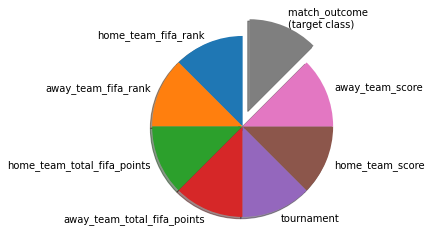

<Figure size 432x288 with 0 Axes>

In [13]:
match_df['rank_difference'] = match_df['home_team_fifa_rank'] - match_df['away_team_fifa_rank']
match_df['average_rank'] = (match_df['home_team_fifa_rank'] + match_df['away_team_fifa_rank'])/2
match_df['point_difference'] = match_df['home_team_total_fifa_points'] - match_df['away_team_total_fifa_points']
# match_df['offense_difference'] = match_df['home_team_mean_offense_score'] - match_df['away_team_mean_offense_score']
# match_df['defense_difference'] = match_df['home_team_mean_defense_score'] - match_df['away_team_mean_defense_score']
# match_df['goalkeeper_difference'] = match_df['home_team_goalkeeper_score'] - match_df['away_team_goalkeeper_score']
match_df['is_stake'] = match_df['tournament'] != 'Friendly'
match_df['is_worldcup'] = True
match_df = match_df[match_df['tournament'].str.contains("FIFA World Cup")]

match_df = match_df.replace({"IR Iran": "Iran", "Korea Republic": "South Korea"})
rank_df = rank_df.replace({"IR Iran": "Iran", "Korea Republic": "South Korea"})

match_df['score_difference'] = match_df['home_team_score'] - match_df['away_team_score'] # Note that this feature is not used in training

match_df['tournament'].value_counts()

def transform_match_outcome(result):
    if int(result) > 0:
        return 1
    else:
        return 0

match_df['match_outcome'] = match_df['score_difference'].map(transform_match_outcome)

# print(match_df['score_difference'])
# print(match_df['match_outcome'])
# match_df = match_df.fillna(0)
print("\n======================================== PROCESSED WORLD CUP MATCHES DATAFRAME ========================================\n")
# print(list(match_df))
# match_df['date'] = pd.to_datetime(match_df['date'])
# match_df = match_df[~(match_df['date'] < '2011-08-21')]
feature_df = match_df.loc[:,['home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points', 'tournament', 'home_team_score', 'away_team_score', 'match_outcome']]
feature_df.info()
print()
print(list(feature_df))
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'home_team_fifa_rank', 'away_team_fifa_rank', 'home_team_total_fifa_points', 'away_team_total_fifa_points', 'tournament', 'home_team_score', 'away_team_score', 'match_outcome \n(target class)'
sizes = [12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5, 12.5]
explode = (0, 0, 0, 0, 0, 0, 0, 0.20)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels,
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
# plt.savefig('features.eps', format='eps')
plt.clf()

In [14]:
X, y = match_df.loc[:,['average_rank', 'rank_difference', 'point_difference', \
                        # 'offense_difference', 'defense_difference', 'goalkeeper_difference' \
                        ]], match_df['match_outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=64)
X, y

(       average_rank  rank_difference  point_difference
 0              40.5               37                 0
 2              64.5              -59                 0
 4              36.0               62                 0
 5              44.5               51                 0
 10             49.0                6                 0
 ...             ...              ...               ...
 23634         126.5               31               -89
 23654          33.0               12               -63
 23723          22.5               -9                53
 23876          32.0               20              -100
 23890          66.0              -70               297
 
 [5960 rows x 3 columns],
 0        1
 2        1
 4        0
 5        0
 10       1
         ..
 23634    0
 23654    0
 23723    1
 23876    0
 23890    1
 Name: match_outcome, Length: 5960, dtype: int64)

## 3. Comparisons between Algorithms

### 3.a.Train VS Test Accuracies

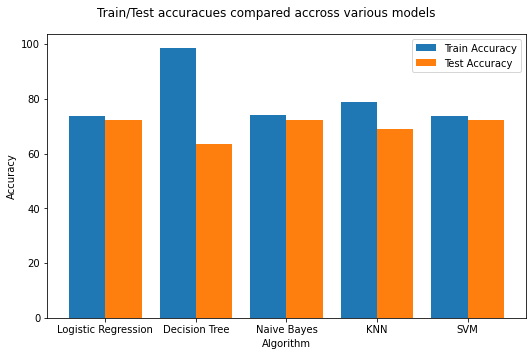

<Figure size 540x360 with 0 Axes>

In [15]:
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'KNN', 'SVM']
model_classes = [LogisticRegression(), DecisionTreeClassifier(), BernoulliNB(), KNeighborsClassifier(), SVC()]

def get_accuracies(model_object):
    model = model_object
#     print(model)
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)*100
    test_acc = model.score(X_test, y_test)*100
    return train_acc, test_acc

train_accuracies, test_accuracies = [], []
for each_model in model_classes:
    train_acc, test_acc = get_accuracies(each_model)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
#     print(train_acc, test_acc)

train_accuracies, test_accuracies
  
X_axis = np.arange(len(model_names))

plt.rcParams["figure.figsize"] = [7.5, 5]
plt.rcParams["figure.autolayout"] = True

plt.bar(X_axis - 0.2, train_accuracies, 0.4, label = 'Train Accuracy')
plt.bar(X_axis + 0.2, test_accuracies, 0.4, label = 'Test Accuracy')

plt.xticks(X_axis, model_names)
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.suptitle("Train/Test accuracues compared accross various models")
plt.legend()
plt.show()
# plt.savefig('accuracies.eps', format='eps')
plt.clf()

### 3.b. 10-Fold Cross Validation

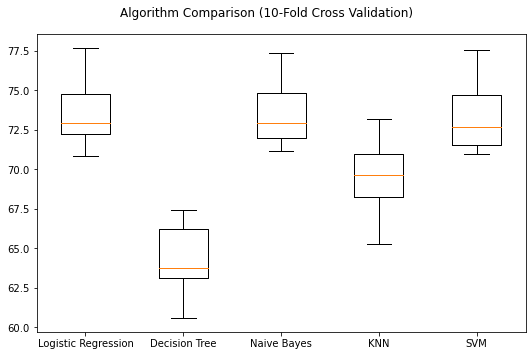

In [16]:
models = []
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'KNN', 'SVM']
model_classes = [LogisticRegression(), DecisionTreeClassifier(), BernoulliNB(), KNeighborsClassifier(), SVC()]
for name, model in zip(model_names, model_classes):
    models.append((name, model))
results, names = [], []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
	results.append(cv_results*100)
	names.append(name)
fig = plt.figure()
fig.suptitle('Algorithm Comparison (10-Fold Cross Validation)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()
# plt.savefig('cross_validation.eps', format='eps')

### 3.c. ROC/AUC Curves

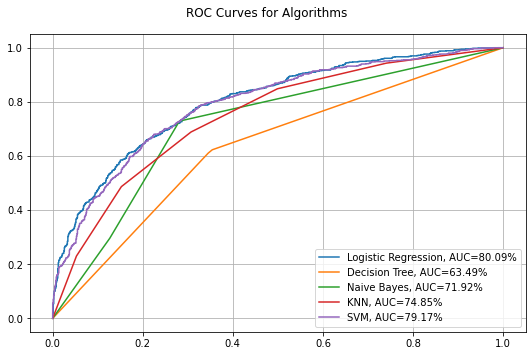

<Figure size 540x360 with 0 Axes>

In [17]:
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'KNN', 'SVM']
model_classes = [LogisticRegression(), DecisionTreeClassifier(), BernoulliNB(), KNeighborsClassifier(), SVC(probability=True)]

def plot_roc(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    plt.plot(fpr,tpr,label="{}, AUC={}%".format(name, str(round(auc*100, 2))))

for name, model in zip(model_names, model_classes):
    plot_roc(name, model)

plt.suptitle('ROC Curves for Algorithms')
plt.legend()
plt.grid()
plt.show()
# plt.savefig('roc.eps', format='eps')
plt.clf()

### 3.d. AdaBoost with Decision Trees

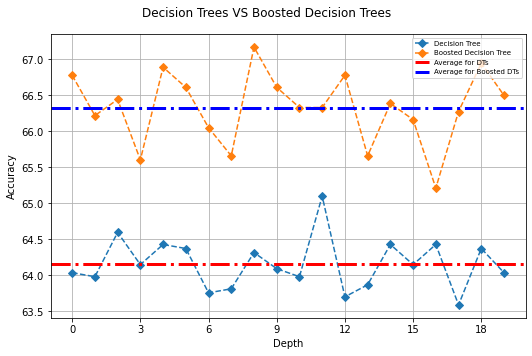

<Figure size 540x360 with 0 Axes>

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns

depths = 20
dt_acc, boosted_dt_acc = [], []
for depth in range(1, depths+1, 1):
    regr_1 = DecisionTreeClassifier(max_depth=depths)

    regr_2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depths))

    regr_1.fit(X_train, y_train)
    regr_2.fit(X_train, y_train)

    y_1 = regr_1.score(X_test, y_test)*100
    y_2 = regr_2.score(X_test, y_test)*100

#     print(y_1, y_2)
    dt_acc.append(y_1)
    boosted_dt_acc.append(y_2)

import matplotlib.pyplot as plt
import numpy as np

plt.plot(dt_acc, label = 'Decision Tree', linestyle='--', marker='D')
plt.plot(boosted_dt_acc, label = 'Boosted Decision Tree', linestyle='--', marker='D')
plt.axhline(y=np.nanmean(dt_acc), color='red', linestyle='-.', linewidth=3, label='Average for DTs')
plt.axhline(y=np.nanmean(boosted_dt_acc), color='blue', linestyle='-.', linewidth=3, label='Average for Boosted DTs')

plt.rcParams["figure.figsize"] = [7.5, 5]
plt.rcParams["figure.autolayout"] = True

plt.suptitle('Decision Trees VS Boosted Decision Trees')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend(loc='upper right', prop={'size': 7})
plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()
# plt.savefig('boosted_dt.eps', format='eps')
plt.clf()

### 3.e. Confusion Matrix, Precision, Recall and F-1 Score

In [19]:
plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.autolayout"] = True

def plot_confusion_mat(name, model):
    color = 'black'
    matrix = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, display_labels=['Loss/Draw', 'Win'])
    matrix.ax_.set_title(name + ' - Confusion Matrix', color=color)
    plt.xlabel('Predicted Label', color=color)
    plt.ylabel('True Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()
#     plt.savefig('cm_{}.eps'.format(name.replace(" ", "_").lower()), format='eps')

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'KNN', 'SVM']
model_classes = [LogisticRegression(), DecisionTreeClassifier(), BernoulliNB(), KNeighborsClassifier(), SVC(probability = True)]

def plot_roc(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('\n================================ ' + name + ' ================================')
#     plot_confusion_mat(name, model)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n")
    print_cm(cm, ['Loss/Draw', 'Win'])
    print("\nMetrics: \n")
    print(classification_report(y_test, y_pred, target_names = ['Loss/Draw', 'Win']))

for name, model in zip(model_names, model_classes):
    plot_roc(name, model)

# plt.suptitle('ROC Curves for Algorithms')
# plt.legend()
# plt.show()


================================ Logistic Regression ================================
Confusion Matrix: 

              Loss/Draw       Win 
    Loss/Draw       654       238 
          Win       260       636 

Metrics: 

              precision    recall  f1-score   support

   Loss/Draw       0.72      0.73      0.72       892
         Win       0.73      0.71      0.72       896

    accuracy                           0.72      1788
   macro avg       0.72      0.72      0.72      1788
weighted avg       0.72      0.72      0.72      1788


================================ Decision Tree ================================
Confusion Matrix: 

              Loss/Draw       Win 
    Loss/Draw       597       295 
          Win       358       538 

Metrics: 

              precision    recall  f1-score   support

   Loss/Draw       0.63      0.67      0.65       892
         Win       0.65      0.60      0.62       896

    accuracy                           0.63      1788
   macro avg 

## 4. Algorithms Used - Own Implementation

### 4.a. Logistic Regression

In [20]:
class LogisticRegression:
    def __init__(self):
        self.learning_rate=0.1
        self.iterations=100
        self.weights=[]
        self.gradients=[]
        self.labelWithWeights={}

    def sigmoid(self,z):
        return 1/(1+math.exp(-z))

    def fit(self,X,Y):
        for t in np.unique(Y):
            y=[]
            #for s in range(len(Y)):
            y=np.where(t==Y,1,0)
            self.weights=np.zeros(len(X[0]))
            for k in range(self.iterations):
                self.gradients=np.zeros(len(X[0]))
                for i in range(len(X)):
                    prediction=self.sigmoid(np.dot(self.weights,X[i]))
                    error=y[i]-prediction
                    for j in range(len(X[0])):
                        self.gradients[j]=self.gradients[j]-(error*X[i][j])
                    self.gradients=[i/len(X) for i in self.gradients]
                    #print("self.gradients",self.gradients)
                    self.weights=[self.weights[l]-(self.learning_rate*self.gradients[l]) for l in range(len(X[0]))]
            self.labelWithWeights[t]=self.weights

    def predict_example(self,x):
        dict={}
        for key in self.labelWithWeights.keys():
            dict[key]=self.sigmoid(np.dot(self.labelWithWeights[key],x))
        return max(dict,key=dict.get)

def compute_error(y_true,y_pred):
    errors=[]
    for i in range(len(y_true)):
        if y_true[i]!=y_pred[i]:
            errors.append(1)
        else:
            errors.append(0)
    return float(sum(errors)/len(errors))


================================ Own Implementation ================================
Train Accuracy = 73.99%.
Test Accuracy = 72.76%.
True Positive Rate = 0.77
False Positive Rate = 0.31


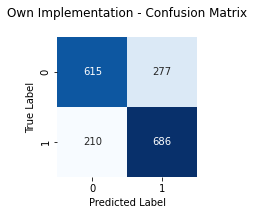


================================ Scikit-Learn ================================
Train Accuracy = 73.87%.
Test Accuracy = 72.15%.
True Positive Rate = 0.71
False Positive Rate = 0.27


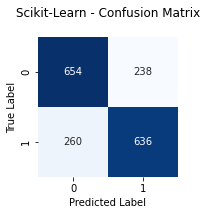

<Figure size 360x216 with 0 Axes>

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression as lr

plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.autolayout"] = True

ytrn = np.asarray(y_train.values.tolist())
Xtrn = np.asarray(X_train.values.tolist())

ytst = np.asarray(y_test.values.tolist())
Xtst = np.asarray(X_test.values.tolist())

name = "Own Implementation"
print('\n================================ ' + name + ' ================================')
logReg=LogisticRegression()
logReg.fit(Xtrn,ytrn)
y_pred = [logReg.predict_example(x) for x in Xtrn]
trn_err = compute_error(ytrn, y_pred)
y_pred = [logReg.predict_example(x) for x in Xtst]
tst_err = compute_error(ytst, y_pred)
print('Train Accuracy = {0:4.2f}%.'.format((1-trn_err) * 100))
print('Test Accuracy = {0:4.2f}%.'.format((1-tst_err) * 100))
matrix_confusion = confusion_matrix(ytst, y_pred)
tn, fp, fn, tp = matrix_confusion.ravel()
# print(tn, fp, fn, tp)
tpr, fpr = tp / (tp + fn), fp / (fp + tn)
print('True Positive Rate = {0:4.2f}'.format(tpr))
print('False Positive Rate = {0:4.2f}'.format(fpr))
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.suptitle(name + ' - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# plt.savefig('own_lr.eps', format='eps')
plt.clf()
    
name = "Scikit-Learn"
print('\n================================ ' + name + ' ================================')
sklearn = lr(max_iter=100,multi_class='ovr')
sklearn.fit(Xtrn, ytrn)
y_pred = sklearn.predict(Xtrn)
trn_err = compute_error(ytrn, y_pred)
y_pred = sklearn.predict(Xtst)
tst_err = compute_error(ytst, y_pred)
print('Train Accuracy = {0:4.2f}%.'.format((1-trn_err) * 100))
print('Test Accuracy = {0:4.2f}%.'.format((1-tst_err) * 100))
matrix_confusion = confusion_matrix(ytst, y_pred)
tn, fp, fn, tp = matrix_confusion.ravel()
# print(tn, fp, fn, tp)
tpr, fpr = tp / (tp + fn), fp / (fp + tn)
print('True Positive Rate = {0:4.2f}'.format(tpr))
print('False Positive Rate = {0:4.2f}'.format(fpr))
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.suptitle(name + ' - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# plt.savefig('sklearn_lr.eps', format='eps')
plt.clf()

### 4.b. Naive Bayes

In [22]:
class NaiveBayes:
    def __init__(self):
        self.dict_probability_x={}

    def partition(self,x):
        result = {}
        v = np.unique(x)
        sol = []
        for i in v:
            temp_sol = []
            for j in range(len(x)):
                if (i == x[j]):
                    temp_sol.append(j)
            sol.append(temp_sol)
        for i in range(len(v)):
            result[v[i]] = sol[i]
        return result

    def fit(self,X,y):
        # print(self.partition(Y))
        for i in range(len(X.T)):
            for key_y,value_y in self.partition(y).items():
                for key_x in self.partition((X.T)[i]).keys():
                    nx=0
                    ny=len(value_y)
                    for j in value_y:
                        # print("j",j)
                        # print("(X.T)[i]", (X.T)[i])
                        if ((X.T)[i])[j]==key_x:
                            nx=nx+1
                    self.dict_probability_x[(key_x,key_y,i)]=(nx,ny)
        # print(self.dict_probability_x)

    def predict_example(self,X,y):
        result={}
        for i in np.unique(y):
            initial=1
            for j in range(len(X)):
                initial=initial*float(self.dict_probability_x[(X[j],i,j)][0]/self.dict_probability_x[(X[j],i,j)][1])
            result[i]=initial*float(len(self.partition(y)[i])/len(y))
        return max(result,key=result.get)
    
def compute_error(y_true, y_pred):
    errors = []
    for i in range(len(y_true)):
        if y_true[i] != y_pred[i]:
            errors.append(1)
        else:
            errors.append(0)
    return float(sum(errors) / len(errors))


================================ Own Implementation ================================
Train Accuracy = 74.02%.
Test Accuracy = 72.37%.
True Positive Rate = 0.73
False Positive Rate = 0.28


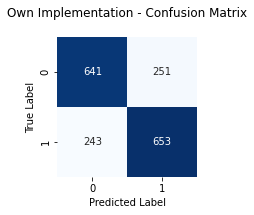


================================ Scikit-Learn ================================
Train Accuracy = 74.02%.
Test Accuracy = 72.37%.
True Positive Rate = 0.73
False Positive Rate = 0.28


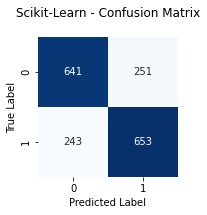

<Figure size 360x216 with 0 Axes>

In [25]:
from sklearn.naive_bayes import BernoulliNB as bnb

ytrn = np.asarray(y_train.values.tolist())
Xtrn = np.asarray(X_train.values.tolist())

ytst = np.asarray(y_test.values.tolist())
Xtst = np.asarray(X_test.values.tolist())

mean_average_rank_train=np.mean(Xtrn[:,0])
mean_rank_difference_train=np.mean(Xtrn[:,1])
mean_point_difference_train=np.mean(Xtrn[:,2])
mean_average_rank_test = np.mean(Xtst[:, 0])
mean_rank_difference_test = np.mean(Xtst[:, 1])
mean_point_difference_test = np.mean(Xtst[:, 2])

for i in range(len(Xtrn)):
    Xtrn[i, 0] = 1 if float(Xtrn[i, 0]) > mean_average_rank_train else 0
    Xtrn[i, 1] = 1 if float(Xtrn[i, 1]) > mean_rank_difference_train else 0
    Xtrn[i, 2] = 1 if float(Xtrn[i, 2]) > mean_point_difference_train else 0
for i in range(len(Xtst)):
    Xtst[i, 0] = 1 if float(Xtst[i, 0]) > mean_average_rank_test else 0
    Xtst[i, 1] = 1 if float(Xtst[i, 1]) > mean_rank_difference_test else 0
    Xtst[i, 2] = 1 if float(Xtst[i, 2]) > mean_point_difference_test else 0

plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["figure.autolayout"] = True

name = "Own Implementation"
print('\n================================ ' + name + ' ================================')
nb = NaiveBayes()
nb.fit(Xtrn, ytrn)
y_pred = [nb.predict_example(x,ytrn) for x in Xtrn]
trn_err = compute_error(ytrn, y_pred)
y_pred = [nb.predict_example(x,ytrn) for x in Xtst]
tst_err = compute_error(ytst, y_pred)
print('Train Accuracy = {0:4.2f}%.'.format((1-trn_err) * 100))
print('Test Accuracy = {0:4.2f}%.'.format((1-tst_err) * 100))
matrix_confusion = confusion_matrix(ytst, y_pred)
tn, fp, fn, tp = matrix_confusion.ravel()
tpr, fpr = tp / (tp + fn), fp / (fp + tn)
print('True Positive Rate = {0:4.2f}'.format(tpr))
print('False Positive Rate = {0:4.2f}'.format(fpr))
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.suptitle(name + ' - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# plt.savefig('own_nb.eps', format='eps')
plt.clf()

name = "Scikit-Learn"
print('\n================================ ' + name + ' ================================')
sklearn = bnb()
sklearn.fit(Xtrn, ytrn)
y_pred = sklearn.predict(Xtrn)
trn_err = compute_error(ytrn, y_pred)
y_pred = sklearn.predict(Xtst)
tst_err = compute_error(ytst, y_pred)
print('Train Accuracy = {0:4.2f}%.'.format((1-trn_err) * 100))
print('Test Accuracy = {0:4.2f}%.'.format((1-tst_err) * 100))
matrix_confusion = confusion_matrix(ytst, y_pred)
tn, fp, fn, tp = matrix_confusion.ravel()
tpr, fpr = tp / (tp + fn), fp / (fp + tn)
print('True Positive Rate = {0:4.2f}'.format(tpr))
print('False Positive Rate = {0:4.2f}'.format(fpr))
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.suptitle(name + ' - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
# plt.savefig('sklearn_nb.eps', format='eps')
plt.clf()

### 4.c. Decision Tree

In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score
# import graphviz

def partition(x):
	v = dict()
	for index, value in enumerate(x):
		if value not in v:
			v[value] = [index]
		else:
			v[value].append(index)
	return v

def entropy(y):
	entropy_val, total_val = 0, 0
	for value in y:
		total_val += len(y[value])
	for value in y:
		probability_val = len(y[value]) / total_val
		entropy_val -= probability_val * math.log2(probability_val)
	return entropy_val

def mutual_information(x, y):
	total_val = len(y)
	H_y = entropy(partition(y))	
	unique_vals = partition(x)
	H_yx = 0
	for key in unique_vals:
		classes, class_count = {}, 0
		for index in unique_vals[key]:
			class_count += 1
			if y[index] not in classes:
				classes[y[index]] = [index]
			else:
				classes[y[index]].append(index)
		H_yx += entropy(classes) * (class_count/total_val)
	I_xy = H_y - H_yx
	
	return I_xy

def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
	if attribute_value_pairs == None:
		attribute_value_pairs = []
		for i in range(len(x[0])):
			for key in partition(x[:,i]):
				attribute_value_pairs.append((i,key))
		
	new_depth = depth
	tree = dict()
	unique_elements = np.unique(y, return_counts=True)
	elements = unique_elements[0]
	counts = unique_elements[1]
	majority_label = elements[np.argmax(counts)]

	# Three termination conditions
	if len(elements) == 1:
		# 1. If the entire set of labels (y) is pure (all y = only 0 or only 1), then return that label
		return y[0]	
	elif attribute_value_pairs != None and len(attribute_value_pairs) == 0:
		# 2. If the set of attribute-value pairs is empty (there is nothing to split on), then return
		#    the most common value of y (majority label)
		return majority_label
	elif depth == max_depth:
		# 3. If the max_depth is reached (pre-pruning bias), then return the most common value of y (majority label)
		return majority_label
	else:
		# Continue with Recursion
		information_gain = []
		for (index,value) in attribute_value_pairs:
			information_gain.append(mutual_information(x[:,index] == value,y))

		# If we select (x2, d) as the best attribute-value pair, then the new decision node becomes: 
		# [ (x2 == d)? ] and the attribute-value pair (x2, d) is removed from the list of attribute_value_pairs.

		chosen_pair = attribute_value_pairs[np.argmax(information_gain)]
		best_index, best_value = chosen_pair

		new_pair = []
		for i in attribute_value_pairs:
			if i != chosen_pair:
				new_pair.append(i)

		attribute_value_pairs = new_pair

		# Custom broadcasting vector (x) with a scalar value (best_value) using numpy
		true_condition = x[:,best_index] == best_value
		false_condition = x[:,best_index] != best_value

		x_true, y_true, x_false, y_false = x[true_condition], y[true_condition], x[false_condition], y[false_condition]
		
		new_depth += 1

		if len(y_true):
			tree[best_index, best_value, True] = id3(x_true, y_true, attribute_value_pairs, depth=new_depth, max_depth=max_depth)
		
		if len(y_false):
			tree[best_index, best_value, False] = id3(x_false, y_false, attribute_value_pairs, depth=new_depth, max_depth=max_depth)
	
	return tree

def predict_example(x, tree):
	try:
		for node in tree:
			attribute, value, truth_value = node
			if value == x[attribute] and truth_value == True:
				return predict_example(x, tree[node])
			elif value != x[attribute] and truth_value == False:
				return predict_example(x, tree[node])
	except TypeError as te:
		return tree

def compute_error(y_true, y_pred):
	return (1/len(y_true)) * sum(y_true != y_pred)

In [30]:
ytrn = np.asarray(y_train.values.tolist())
Xtrn = np.asarray(X_train.values.tolist())

ytst = np.asarray(y_test.values.tolist())
Xtst = np.asarray(X_test.values.tolist())
# print(Xtrn, ytrn)

depth_accuracies = []
for depth in range(1, 20+1, 1):
	decision_tree = id3(Xtrn, ytrn, max_depth=depth+1)
	y_pred = [predict_example(x, decision_tree) for x in Xtst]
	tst_err = compute_error(ytst, y_pred)
	accuracy = (1 - tst_err) * 100
	print('Depth = ', depth)
	depth_accuracies.append(accuracy)
	print('Accuracy = {0:4.2f}%.\n'.format(accuracy))

Depth =  1
Accuracy = 50.00%.

Depth =  2
Accuracy = 50.28%.

Depth =  3
Accuracy = 50.56%.

Depth =  4
Accuracy = 50.56%.

Depth =  5
Accuracy = 50.78%.

Depth =  6
Accuracy = 50.78%.

Depth =  7
Accuracy = 50.78%.

Depth =  8
Accuracy = 50.78%.

Depth =  9
Accuracy = 51.06%.

Depth =  10
Accuracy = 51.06%.

Depth =  11
Accuracy = 51.29%.

Depth =  12
Accuracy = 51.23%.

Depth =  13
Accuracy = 51.23%.

Depth =  14
Accuracy = 51.23%.

Depth =  15
Accuracy = 52.57%.

Depth =  16
Accuracy = 52.91%.

Depth =  17
Accuracy = 52.85%.

Depth =  18
Accuracy = 52.96%.

Depth =  19
Accuracy = 52.96%.

Depth =  20
Accuracy = 52.96%.



In [33]:
depth_list = [x for x in range(1, 21, 1)]
sklearn_accuracies = []
for depth in range(1, 21, 1):
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    Y_pred = decision_tree.predict(X_test)
    acc_decision_tree = round(decision_tree.score(X_test, y_test) * 100, 2)
#     print(acc_decision_tree)
    sklearn_accuracies.append(acc_decision_tree)

acc_custom_dt = depth_accuracies
acc_dt = sklearn_accuracies

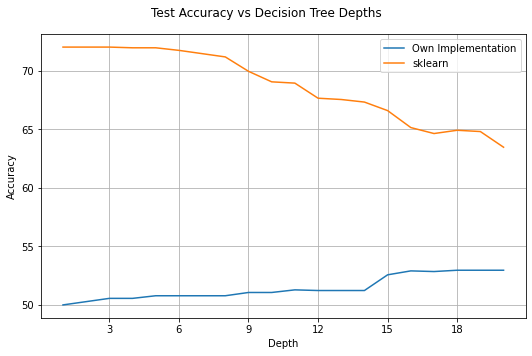

<Figure size 540x360 with 0 Axes>

In [34]:
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = [7.5, 5]
plt.rcParams["figure.autolayout"] = True

plt.plot(depth_list, acc_custom_dt, label = 'Own Implementation')
plt.plot(depth_list, acc_dt, label = 'sklearn')
plt.suptitle('Test Accuracy vs Decision Tree Depths')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.axes().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xlim([0, 21])
plt.grid()
plt.show()
# plt.savefig('own_dt.eps', format='eps')
plt.clf()

## 5. World Cup Simulation

In [35]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
model = logreg

rank_df = rank_df.loc[(rank_df['rank_date'] == rank_df['rank_date'].max()) & (rank_df['country_full'].isin(teams_df['Team'].unique()))]

worldcup_rankings = rank_df.set_index(['country_full'])

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup = teams_df.set_index(['Team'])
world_cup['points'] = 0
world_cup['total_prob'] = 0
world_cup['expected points'] = 0
world_cup['rank'] = None

country_win_prob = {}

for country in teams_df['Team'].unique():
    country_win_prob[country] = list()
    
for group in sorted(set(teams_df['Group'])):
    for home, away in combinations(teams_df.query('Group == "{}"'.format(group)).values, 2):
    
        home, away = home[0], away[0]
        
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_train.columns)

        home_rank = worldcup_rankings.loc[home, 'rank']
        home_points = worldcup_rankings.loc[home, 'total_points']
        opp_rank = worldcup_rankings.loc[away, 'rank']
        opp_points = worldcup_rankings.loc[away, 'total_points']
        world_cup.loc[home, 'rank'] = home_rank
        world_cup.loc[away, 'rank'] = opp_rank

        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]

        country_win_prob[home].append(home_win_prob)
        country_win_prob[away].append(1-home_win_prob)

team_group_map = {}
for team, group in zip(list(teams_df['Team']), list(teams_df['Group'])):
    team_group_map[team] = group

country_total_prob = []

for country in country_win_prob.keys():

    win_prob_list = country_win_prob[country]

    total_prob = 0
    temp = 1
    for i in range(3):
        temp = temp * win_prob_list[i]

    total_prob += temp

    for i in range(3):
        temp = 1
        for j in range(3):
            if i == j:
                temp = temp * (1 - win_prob_list[i])
            else:
                temp = temp * win_prob_list[i]
        total_prob += temp
    
    country_total_prob.append([country, total_prob, team_group_map[country]])

country_total_prob = sorted(country_total_prob, key=lambda x: x[1], reverse=True)

country_total_prob.sort(key=lambda x:x[1], reverse=True)

prob_df = pd.DataFrame(country_total_prob, columns =['Country', 'Probability', 'Group']) 
top_16 = [i[0] for i in country_total_prob[:len(country_total_prob)//2]]
print('Top 16 teams: ')
print(', '.join(top_16))

Top 16 teams: 
Netherlands, Belgium, Brazil, France, Portugal, Argentina, Spain, England, Mexico, Uruguay, Senegal, Denmark, Croatia, Germany, USA, Switzerland


In [37]:
round_of_16 = {}
for team, probability, group in country_total_prob:
    if group not in round_of_16:
        round_of_16[group] = [[team, probability, group]]
    elif len(round_of_16[group]) <= 1:
        round_of_16[group].append([team, probability, group])

def who_wins(home, away):
    winner = ['', 0]
    
    row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan]]), columns=X_train.columns)

    home_rank = worldcup_rankings.loc[home, 'rank']
    home_points = worldcup_rankings.loc[home, 'total_points']
    opp_rank = worldcup_rankings.loc[away, 'rank']
    opp_points = worldcup_rankings.loc[away, 'total_points']

    row['average_rank'] = (home_rank + opp_rank) / 2
    row['rank_difference'] = home_rank - opp_rank
    row['point_difference'] = home_points - opp_points

    # Model Output
    home_win_prob = model.predict_proba(row)[:,1][0]

    country_win_prob[home].append(home_win_prob)
    country_win_prob[away].append(1-home_win_prob)

    points = 0
    if home_win_prob <= 0.5:
        winner[0] = away
        winner[1] = 1-home_win_prob
    if home_win_prob >= 0.5:
        winner[0] = home
        winner[1] = home_win_prob
    return winner

quarter_finals = {}

for group in round_of_16:
    winner1 = who_wins(round_of_16[group][0][0], round_of_16[group][1][0])
    winner2 = who_wins(round_of_16[group][1][0], round_of_16[group][0][0])
    
    quarter_finals[group] = winner1 if winner1[1] > winner2[1] else winner2
quarter_finalists = [quarter_finals[group][0] for group in quarter_finals]
print('Quarter Finalists (top 8): ')
print(', '.join(quarter_finalists))

groupwise_quarterfinals = collections.OrderedDict(sorted(quarter_finals.items()))
groupwise_quarterfinals

grouping = {'A': 'C', 'B': 'D', 'E': 'G', 'F': 'H'}
quarter_finals

quarter_final_winners = []
semifinals = []

for group in groupwise_quarterfinals:
    if group in grouping:
        quarter_final_winners.append(groupwise_quarterfinals[group])
        winner1 = who_wins(groupwise_quarterfinals[group][0], groupwise_quarterfinals[grouping[group]][0])
        winner2 = who_wins(groupwise_quarterfinals[grouping[group]][0], groupwise_quarterfinals[group][0])
        winner = winner1 if winner1[1] > winner2[1] else winner2
        semifinals.append(winner)

semifinalists = [team[0] for team in semifinals]
print('\nSemifinalists (top 4): ')
print(', '.join(semifinalists))

semifinals
finals = []

for each_team in range(len(semifinals)//2):
#     print(semifinals[each_team], semifinals[each_team+2])
    winner1 = who_wins(semifinals[each_team][0], semifinals[each_team+2][0])
    winner2 = who_wins(semifinals[each_team+2][0], semifinals[each_team][0])
    winner = winner1 if winner1[1] > winner2[1] else winner2
    finals.append(winner)

finalists = [team[0] for team in finals]
print('\nFinalists (top 2): ')
print(', '.join(finalists))
winner1 = who_wins(finals[0][0], finals[1][0])
winner2 = who_wins(finals[1][0], finals[0][0])
world_cup_winner = winner1 if winner1[1] > winner2[1] else winner2

print('\nWinner: ')
print('{} wins'.format(world_cup_winner[0]), end = ' ')
print('with {0:.2f}% probability'.format(world_cup_winner[1]*100))

# who_wins('Spain', 'Morocco')

Quarter Finalists (top 8): 
Netherlands, Belgium, Brazil, France, Portugal, Argentina, Spain, England

Semifinalists (top 4): 
Argentina, France, Brazil, Belgium

Finalists (top 2): 
Brazil, Belgium

Winner: 
Brazil wins with 53.75% probability


# 6. References

- https://www.kaggle.com/code/agostontorok/soccer-world-cup-2018-winner/notebook
- https://gist.github.com/zachguo/10296432?permalink_comment_id=2069674#gistcomment-2069674
- https://towardsdatascience.com/predicting-the-fifa-world-cup-2022-with-a-simple-model-using-python-6b34bdd4f2a5
- https://neptune.ai/blog/how-to-compare-machine-learning-models-and-algorithms
- https://iq.opengenus.org/bernoulli-naive-bayes/
- https://github.com/AssemblyAI-Examples/Machine-Learning-From-Scratch
- https://vasugupta2000.medium.com/implementation-of-gradient-ascent-using-logistic-regression-7f5343877c21